# Genuine Parts PO & Invoice processing

In [48]:
!pwd

/home/jupyter/genco


In [50]:
# TODO - JT only
# path = "/home/jupyter/genco/docai-po-invoice-val"
# os.chdir(path)

## Notes

### references

* [Handling the processing response](https://cloud.google.com/document-ai/docs/handle-response)

### DocAI processing

**Document AI Python SDK**
* [SDk documentation](https://cloud.google.com/python/docs/reference/documentai/latest)
* [SDK source code](https://github.com/googleapis/google-cloud-python/tree/main/packages/google-cloud-documentai) (GitHub)
* [Python code examples](https://cloud.google.com/document-ai/docs/samples?language=python)

**Online (synchronous) requests**
* [documentation](https://cloud.google.com/document-ai/docs/send-request#online-process) 
* lets you send a single document for processing. Document AI processes the request and returns a [`document`](https://cloud.google.com/document-ai/docs/reference/rest/v1/Document)

**Batch (asynchronous) requests**
* [documentation](https://cloud.google.com/document-ai/docs/send-request#batch-process) 
* lets you send multiple documents in a single request. 
* Document AI responds with an operation that you can poll for the status of the request. 
* When this [`operation`](https://cloud.google.com/document-ai/docs/reference/rest/v1/projects.locations.operations) finishes, it contains a [`BatchProcessMetadata`](https://cloud.google.com/document-ai/docs/reference/rest/Shared.Types/BatchProcessMetadata) that points to the Cloud Storage bucket where the processed results are stored.

**Processor Types**
* [INVOICE_PROCESSOR](https://cloud.google.com/document-ai/docs/processors-list#processor_invoice-processor)

#### pre reqs

1. Ensure you have a Document AI Warehouse instance in your project. You can follow [this quickstart](https://cloud.google.com/document-warehouse/docs/quickstart) to complete the setup.
2. Create a Document AI [Invoice processor](https://cloud.google.com/document-ai/docs/processors-list#processor_invoice-processor) and update the `DOCAI_PROCESSOR_ID` variable below.
3. If you are using a Vertex AI Workbench Managed Notebook, ensure to grant the following roles:
> * [roles/contentwarehouse.documentAdmin](https://cloud.google.com/document-warehouse/docs/manage-access-control)
> * [roles/documentai.apiUser](https://cloud.google.com/document-ai/docs/access-control/iam-roles)

# Notebook setup

> see `00-env-setup`

In [1]:
USE_CASE                  = 'invoice-recon'  # TODO
ACTOR_PREFIX              = 'gpc'            # TODO
VERSION                   = 'v1'             # TODO

print(f"ACTOR_PREFIX      : {ACTOR_PREFIX}")
print(f"VERSION           : {VERSION}")
print(f"USE_CASE          : {USE_CASE}")

ACTOR_PREFIX      : gpc
VERSION           : v1
USE_CASE          : invoice-recon


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

BUCKET_NAME              = f'a-{ACTOR_PREFIX}-{VERSION}-{USE_CASE}'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

print(f"BUCKET_NAME        : {BUCKET_NAME}")
print(f"BUCKET_URI         : {BUCKET_URI}")

BUCKET_NAME        : a-gpc-v1-invoice-recon
BUCKET_URI         : gs://a-gpc-v1-invoice-recon


In [3]:
config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

ACTOR_PREFIX             = "gpc"
VERSION                  = "v1"
ACTOR_NAME               = "genuine_parts"

BUCKET_NAME              = "a-gpc-v1-invoice-recon"
BUCKET_URI               = "gs://a-gpc-v1-invoice-recon"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

MY_BQ_DATASET            = "a_gpc_v1_invoice_recon"



### imports

In [7]:
from google.cloud import aiplatform as vertex_ai
print(f"Vertex SDK Version: {vertex_ai.__version__}")

from google.cloud import storage
from google.cloud import bigquery

from google.cloud import documentai
from google.cloud.documentai_v1 import Document

Vertex SDK Version: 1.29.0


In [12]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
vertex_ai.init(project=PROJECT_ID, location=LOCATION)

# bigquery client
bqclient = bigquery.Client(
    project=PROJECT_ID,
    # location=LOCATION
)

DOC_AI_LOCATION = "us"

docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{DOC_AI_LOCATION}-documentai.googleapis.com")
)

In [79]:
import sys
import os
import io
import json
import base64
import requests
import concurrent.futures
import time
import numpy as np
import pandas as pd
import uuid

import PyPDF2
import IPython
# import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
# from PIL import Image, ImageDraw

import logging
logging.basicConfig(level = logging.INFO)

### copy local pdf docs to Cloud Storage

In [19]:
PDF_INVOICE_PREFIX = "pdf-invoices"
PDF_INVOICE_DIR_URI = f"{BUCKET_URI}/{PDF_INVOICE_PREFIX}"

print(f"PDF_INVOICE_DIR_URI : {PDF_INVOICE_DIR_URI}")

PDF_INVOICE_DIR_URI : gs://a-gpc-v1-invoice-recon/pdf-invoices


In [17]:
!gsutil cp invoices/*.pdf $PDF_INVOICE_DIR_URI

Copying file://invoices/form_with_tables.pdf [Content-Type=application/pdf]...
Copying file://invoices/google_invoice.pdf [Content-Type=application/pdf]...    
Copying file://invoices/gpc-receipt-1.pdf [Content-Type=application/pdf]...     
Copying file://invoices/invoice.pdf [Content-Type=application/pdf]...           
/ [4 files][440.9 KiB/440.9 KiB]                                                
Operation completed over 4 objects/440.9 KiB.                                    


In [18]:
!gsutil ls $PDF_INVOICE_DIR_URI

gs://a-gpc-v1-invoice-recon/pdf-invoices/form_with_tables.pdf
gs://a-gpc-v1-invoice-recon/pdf-invoices/google_invoice.pdf
gs://a-gpc-v1-invoice-recon/pdf-invoices/gpc-receipt-1.pdf
gs://a-gpc-v1-invoice-recon/pdf-invoices/invoice.pdf


In [20]:
pdf_files = []
pdf_blobs = []

for blob in storage_client.list_blobs(BUCKET_NAME, prefix=f'{PDF_INVOICE_PREFIX}'):
    if '.pdf' in blob.name:
        pdf_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        pdf_blobs.append(blob.name)

In [21]:
pdf_files

['gs://a-gpc-v1-invoice-recon/pdf-invoices/form_with_tables.pdf',
 'gs://a-gpc-v1-invoice-recon/pdf-invoices/google_invoice.pdf',
 'gs://a-gpc-v1-invoice-recon/pdf-invoices/gpc-receipt-1.pdf',
 'gs://a-gpc-v1-invoice-recon/pdf-invoices/invoice.pdf']

In [22]:
pdf_blobs

['pdf-invoices/form_with_tables.pdf',
 'pdf-invoices/google_invoice.pdf',
 'pdf-invoices/gpc-receipt-1.pdf',
 'pdf-invoices/invoice.pdf']

## DocAI document processor

### get or create processor

In [10]:
PARSER_DISPLAY_NAME = f"{ACTOR_PREFIX}_{USE_CASE}_{VERSION}".replace("-","_")
PARSER_TYPE = 'INVOICE_PROCESSOR'      # INVOICE_PROCESSOR | FORM_PARSER_PROCESSOR
PARSER_VERSION = 'v1'

print(f"PARSER_DISPLAY_NAME : {PARSER_DISPLAY_NAME}")
print(f"PARSER_TYPE         : {PARSER_TYPE}")
print(f"PARSER_VERSION      : {PARSER_VERSION}")

PARSER_DISPLAY_NAME : gpc_invoice_recon_v1
PARSER_TYPE         : INVOICE_PROCESSOR
PARSER_VERSION      : v1


**references**
* [create_processor - src code](https://github.com/googleapis/google-cloud-python/blob/main/packages/google-cloud-documentai/google/cloud/documentai_v1/services/document_processor_service/client.py#L2117)

In [13]:
INPUT_MIME_TYPE = "application/pdf"

for p in docai_client.list_processors(parent = f'projects/{PROJECT_NUM}/locations/{DOC_AI_LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
        print('Retrieved Existing Parser')

if 'parser' not in locals():
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_NUM}/locations/{DOC_AI_LOCATION}',
        processor = dict(
            display_name = PARSER_DISPLAY_NAME, 
            type_ = PARSER_TYPE, 
            default_processor_version = PARSER_VERSION
        )
    )
    print('Created New Parser')

parser

Created New Parser


name: "projects/934903580331/locations/us/processors/288557e930283e72"
type_: "INVOICE_PROCESSOR"
display_name: "gpc_invoice_recon_v1"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/934903580331/locations/us/processors/288557e930283e72:process"
create_time {
  seconds: 1692385694
  nanos: 991732000
}
default_processor_version: "projects/934903580331/locations/us/processors/288557e930283e72/processorVersions/pretrained-invoice-v1.3-2022-07-15"

In [27]:
PARSER_NAME = parser.name
PARSER_ENDPOINT = parser.process_endpoint
PROCESSOR_ID = PARSER_NAME.split(f'projects/{PROJECT_NUM}/locations/{DOC_AI_LOCATION}/processors/')[1]

print(f"PARSER_NAME     : {PARSER_NAME}")
print(f"PARSER_ENDPOINT : {PARSER_ENDPOINT}")
print(f"PROCESSOR_ID    : {PROCESSOR_ID}")

PARSER_NAME     : projects/934903580331/locations/us/processors/288557e930283e72
PARSER_ENDPOINT : https://us-documentai.googleapis.com/v1/projects/934903580331/locations/us/processors/288557e930283e72:process
PROCESSOR_ID    : 288557e930283e72


### DocAI helper functions

In [38]:
def process_document_sample(
    pdf_path: str,
):
    # Instantiates a client
    client_options = {"api_endpoint": "{}-documentai.googleapis.com".format(DOC_AI_LOCATION)}
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    name = f"projects/{PROJECT_ID}/locations/{DOC_AI_LOCATION}/processors/{PROCESSOR_ID}"

    with open(pdf_path, "rb") as image:
        image_content = image.read()

    # Read the file into memory
    document = {"content": image_content, "mime_type": "application/pdf"}

    # Configure the process request
    request = {"name": name, "raw_document": document}

    # Recognizes text entities in the PDF document
    result = client.process_document(request=request)
    document = result.document
    entities = document.entities
    print("Document processing complete.\n\n")

    # For a full list of Document object attributes, please reference this page: https://googleapis.dev/python/documentai/latest/_modules/google/cloud/documentai_v1beta3/types/document.html#Document  
    types = []
    values = []
    confidence = []
    
    # Grab each key/value pair and their corresponding confidence scores.
    for entity in entities:
        types.append(entity.type_)
        values.append(entity.mention_text)
        confidence.append(round(entity.confidence,4))
        
    # Create a Pandas Dataframe to print the values in tabular format. 
    df = pd.DataFrame({'Type': types, 'Value': values, 'Confidence': confidence})
    display(df)
    
    # if result.human_review_operation:
    #     print ("Triggered HITL long running operation: {}".format(result.human_review_operation))

    return document

In [39]:
def get_text(
    doc_element: dict, 
    document: dict
):
    """
    Document AI identifies form fields by their offsets
    in document text. This function converts offsets
    to text snippets.
    """
    response = ""
    # If a text segment spans several lines, it will
    # be stored in different text segments.
    for segment in doc_element.text_anchor.text_segments:
        start_index = (
            int(segment.start_index)
            if segment in doc_element.text_anchor.text_segments
            else 0
        )
        end_index = int(segment.end_index)
        response += document.text[start_index:end_index]
    return response

## process invoices

In [40]:
invoice_sample = pdf_files[1]

print(f"invoice_sample : {invoice_sample}")

invoice_sample : gs://a-gpc-v1-invoice-recon/pdf-invoices/google_invoice.pdf


In [41]:
local_path = "invoices/google_invoice.pdf"
doc = process_document_sample(pdf_path=local_path)

Document processing complete.




,Type,Value,Confidence
0,due_date,"Sep 30, 2019",0.9865
1,net_amount,"22,379.39",0.9872
2,total_amount,"19,647.68",0.9851
3,invoice_date,"Sep 24, 2019",0.9766
4,total_tax_amount,"1,767.97",0.9387
5,receiver_name,"Jane Smith,",0.8784
6,receiver_address,"1600 Amphitheatre Pkway\nMountain View, CA 94043",0.7679
7,invoice_id,23413561D,0.6043
8,freight_amount,199.99,0.5970
9,invoice_type,,0.5901


see json response

In [145]:
# doc.content
doc.entities[:1]

[text_anchor {
   text_segments {
     start_index: 136
     end_index: 148
   }
   content: "Sep 30, 2019"
 }
 type_: "due_date"
 mention_text: "Sep 30, 2019"
 confidence: 0.9864908456802368
 page_anchor {
   page_refs {
     bounding_poly {
       normalized_vertices {
         x: 0.8304892182350159
         y: 0.16571427881717682
       }
       normalized_vertices {
         x: 0.9237770438194275
         y: 0.16571427881717682
       }
       normalized_vertices {
         x: 0.9237770438194275
         y: 0.18285714089870453
       }
       normalized_vertices {
         x: 0.8304892182350159
         y: 0.18285714089870453
       }
     }
   }
 }
 id: "0"
 normalized_value {
   text: "2019-09-30"
   date_value {
     year: 2019
     month: 9
     day: 30
   }
 }]

## Draw bounding boxes

> We will now use the spatial data returned by the processor to mark our values on the invoice pdf file that we first converted into a jpg

In [45]:
LOCAL_JPG_PATH = "invoices/google_invoice.jpg"

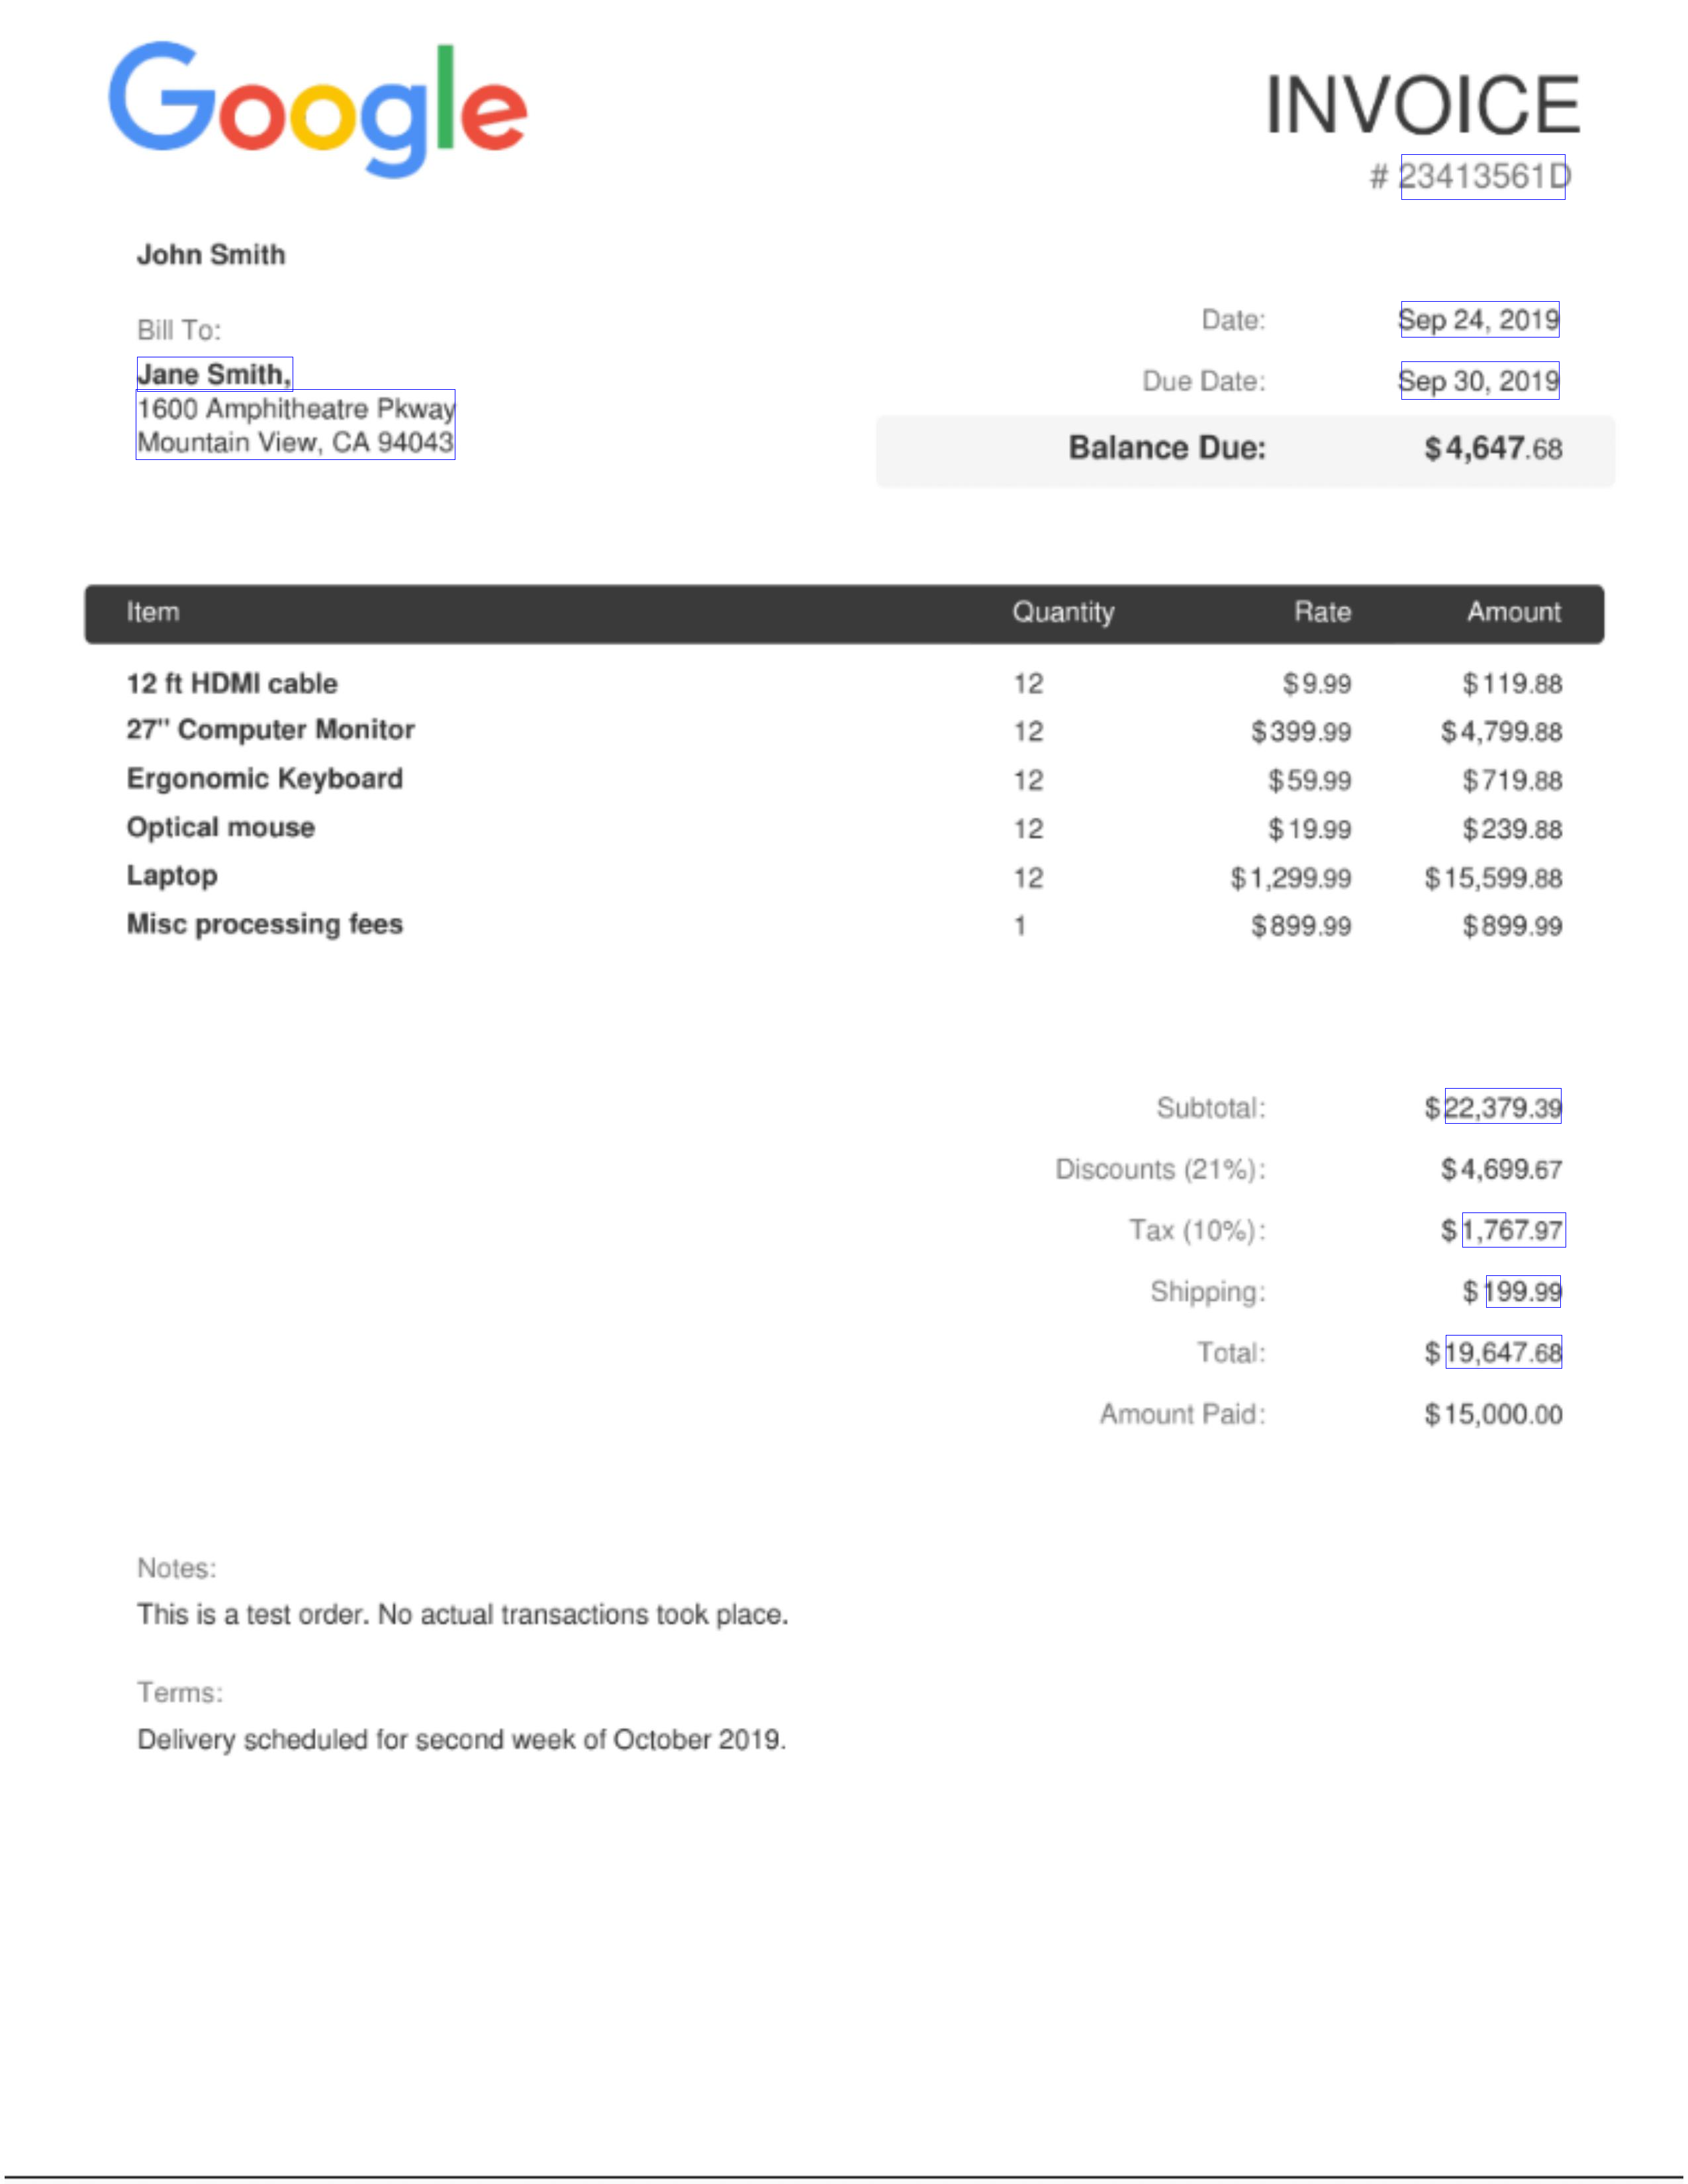

In [140]:
document_image = Image.open(LOCAL_JPG_PATH)

draw = PIL.ImageDraw.Draw(document_image)
count = 0
for entity in doc.entities:
    # Draw the bounding box around the entities
    vertices = []
    # draw = PIL.ImageDraw.Draw(entity)
    for vertex in entity.page_anchor.page_refs[0].bounding_poly.normalized_vertices:
        vertices.append({'x': vertex.x * document_image.size[0], 'y': vertex.y * document_image.size[1]})
    draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']], outline='blue')

    if count == 8:
        break
    count += 1

document_image